<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# The Main Data Loading Pipeline Summarized

The complete chapter code is located in [ch02.ipynb](./ch02.ipynb).

This notebook contains the main takeaway, the data loading pipeline without the intermediate steps.

Packages that are being used in this notebook:

In [3]:
# NBVAL_SKIP
from importlib.metadata import version

# PyTorch is used for tensor operations and building neural networks
# PyTorchはテンソル演算とニューラルネットワークの構築に使用されます
print("torch version:", version("torch"))
# tiktoken is used for tokenizing text according to GPT models
# tiktokenはGPTモデルに従ってテキストをトークン化するために使用されます
print("tiktoken version:", version("tiktoken"))

torch version: 2.9.1
tiktoken version: 0.12.0


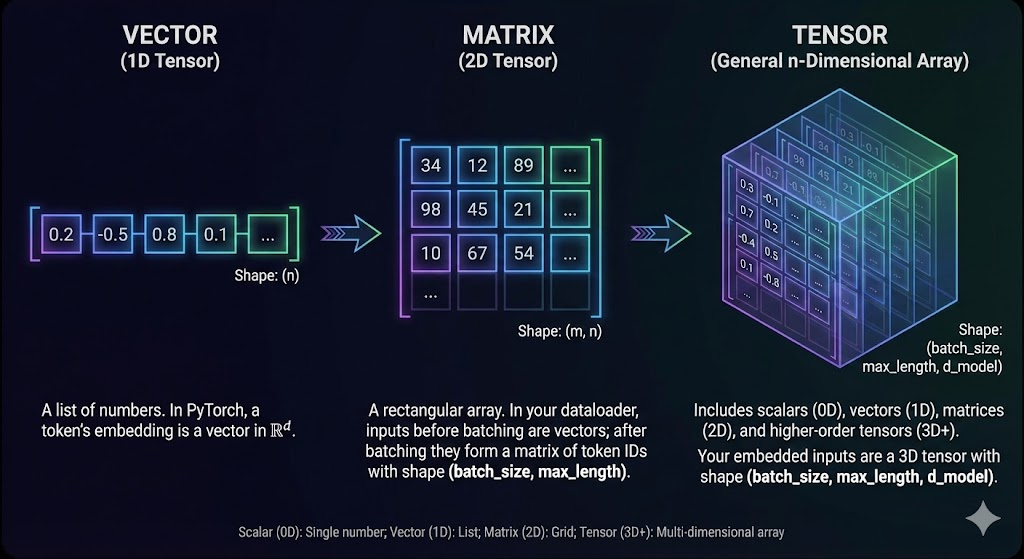
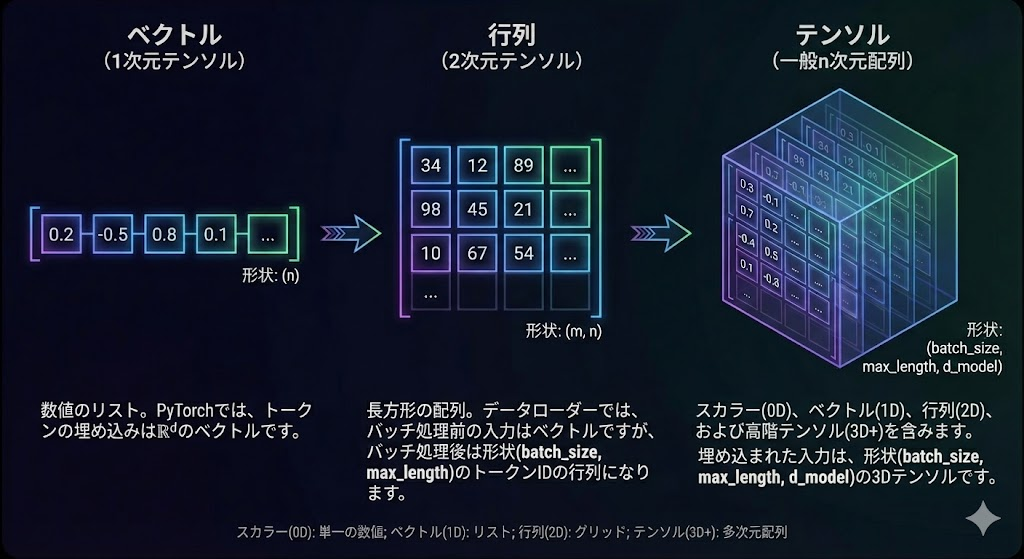
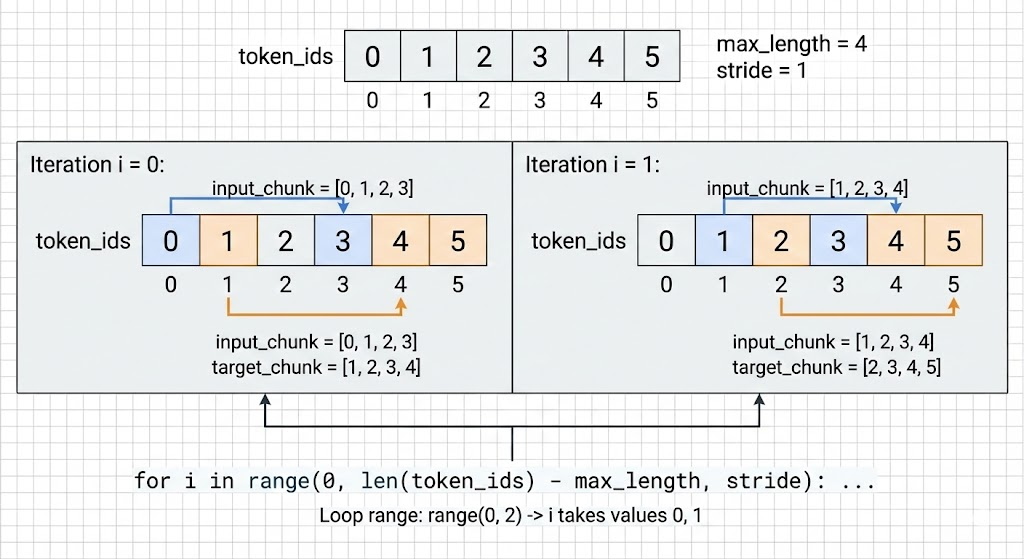

In [4]:
import tiktoken
import torch

# PyTorch is used for tensor operations and neural network computations
# It's an essential package for building and training deep learning models
# PyTorchはテンソル演算とニューラルネットワーク計算に使用されます
# ディープラーニングモデルの構築と訓練に不可欠なパッケージです
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        # Encode the entire text into GPT-2 BPE token IDs, allowing the <|endoftext|> special token
        if not hasattr(tokenizer, "encode"):
            raise TypeError("tokenizer must provide an encode(text, allowed_special=...) method")
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

vocab_size = 50257
output_dim = 256
context_length = 1024


token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

batch_size = 8
max_length = 4
dataloader = create_dataloader_v1(
    raw_text,
    batch_size=batch_size,
    max_length=max_length,
    stride=max_length
)

In [5]:
for batch in dataloader:
    x, y = batch

    token_embeddings = token_embedding_layer(x)
    pos_embeddings = pos_embedding_layer(torch.arange(max_length))

    input_embeddings = token_embeddings + pos_embeddings

    break

In [6]:
print(input_embeddings.shape)

torch.Size([8, 4, 256])
